# CNN for Fashion-MNIST dataset

### Problem Description

We're provided with a dataset of small grayscale images depicting various clothing objects. They are subdivided into ten classes, and our goal is to build a CNN that predicts those classes as precisely as possible. We will build several (simple) CNNs and then compare their performace and efficiency.  

### Loading and preparing the dataset

In [8]:
import warnings
warnings.filterwarnings("ignore")

from random import randrange
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#loading the train and the test set
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


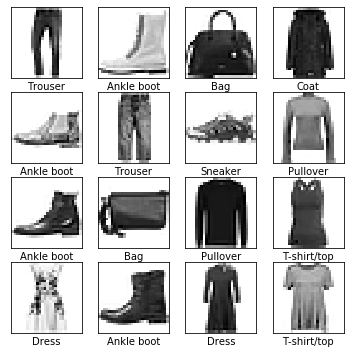

In [10]:
#labeling the classes and displaying some images from the dataset
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(6000)
    plt.imshow(X_train[k], cmap=plt.cm.binary)
    plt.xlabel(class_labels[y_train[k]])
plt.show()


The train and the test sets are given as a three-dimensional vectors. However, in order to feed our CNN with the images, we need them to be 4D vectors. That's why wee need to add an additional dimension. This additional dimension tells the number of channels. Since our images are in grayscale, we have only one channel.

Also, we scale the values of every entry, and one-hot encode the classes.

In [11]:
#Adding the fourth axis
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

In [12]:
#Scaling the values to [0,1] range
X_train = X_train.astype('float')
X_test = X_test.astype('float')

X_train = X_train/255
X_test = X_test/255

In [13]:
#Encoding the classes
from keras.utils import to_categorical

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Building the CNN

Here we build a CNN based on LeNet5 architecture, as given in [`Comparison of Learning Algorithms for Handwritten Digit Recognition`](http://yann.lecun.com/exdb/publis/pdf/lecun-95b.pdf) by Y. LeCun et al.

ReLu and softmax (in the last layer) are used as activation functions. We use the categorical hinge for the loss function, and nadam optimizer.

We perform the training in 90 epochs, which takes approximately 45 minutes, since 1 epoch takes about half a minute to finish. 

(Since I have an integrated Intel graphic card, I had to the train the network using CPU; running it on GPU would allow me to train it significantly faster, for more epochs, which could lead to better accuracy)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from keras.optimizers import nadam
from keras.losses import CategoricalHinge

In [24]:
cnn = Sequential()

cnn.add(Conv2D(input_shape = (28, 28, 1), filters = 6, 
              kernel_size = (5,5), activation = 'relu', padding='same'))
cnn.add(MaxPool2D((2,2)))



cnn.add(Conv2D(filters = 16, 
              kernel_size = (5,5), activation = 'relu',padding='same'))
cnn.add(MaxPool2D((2,2)))


cnn.add(Flatten())

cnn.add(Dense(units = 120, activation='relu'))
cnn.add(Dense(units = 84, activation='relu'))
cnn.add(Dense(units = 10, activation = 'softmax'))

In [25]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 120)               94200     
_________________________________________________________________
dense_11 (Dense)             (None, 84)               

In [26]:
cnn.compile(loss = CategoricalHinge(), 
           optimizer = nadam(lr = 0.001),
           metrics = ['accuracy'])

In [27]:
history = cnn.fit(X_train, y_train, batch_size = 256, epochs = 90, 
        shuffle = True, validation_data= (X_test, y_test), 
        verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/90
60000/60000 [==============================] - 28s 464us/step - loss: 0.5604 - accuracy: 0.7173 - val_loss: 0.4635 - val_accuracy: 0.7619
Epoch 2/90
60000/60000 [==============================] - 27s 456us/step - loss: 0.3457 - accuracy: 0.8301 - val_loss: 0.3625 - val_accuracy: 0.8226
Epoch 3/90
60000/60000 [==============================] - 27s 446us/step - loss: 0.3003 - accuracy: 0.8517 - val_loss: 0.2955 - val_accuracy: 0.8535
Epoch 4/90
60000/60000 [==============================] - 27s 455us/step - loss: 0.2752 - accuracy: 0.8640 - val_loss: 0.2944 - val_accuracy: 0.8534
Epoch 5/90
60000/60000 [==============================] - 27s 447us/step - loss: 0.2536 - accuracy: 0.8753 - val_loss: 0.2645 - val_accuracy: 0.8693
Epoch 6/90
60000/60000 [==============================] - 27s 447us/step - loss: 0.2387 - accuracy: 0.8820 - val_loss: 0.2566 - val_accuracy: 0.8739
Epoch 7/90
60000/60000 [==============================] 

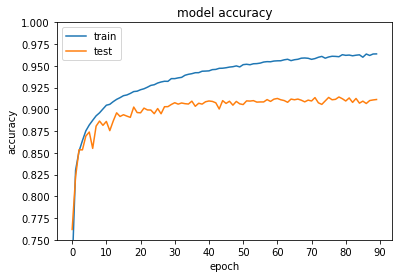

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks(np.arange(0,91,10))
plt.ylim(0.75,1), plt.yticks(np.arange(0.75,1.025,0.025))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Accuracy Analysis

At the end of the training, our model classified the images with the 96.3% accuracy on the training set, and 91.1% on the test set. We can argue some overfit, but still, the performance on the test set is okay. Moreover, if we focus on the test set performance, we can gain the similar accuracy even after ~15 minutes of training (on CPU), since the model achieves it after 30 epochs. 

Let's now draw the confusion matrix for our model, and see how it performs on several randomly chosen images.

In [29]:
from sklearn.metrics import confusion_matrix

y_pred = cnn.predict_classes(X_test)
y_test_class = y_test.argmax(1)

cm = confusion_matrix(y_test_class, y_pred)

In [30]:
import itertools

# Function to plot a confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    # Plot the confusion matrix as an image
    plt.figure(figsize = (14, 14))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 22)
    
    # Tick marks show the labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add the numbers to the plot
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", size = 18,
                 color="white" if cm[i, j] > thresh else "black")

    # Formatting
    plt.tight_layout()
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    plt.ylabel('True label', size = 18)
    plt.xlabel('\n Predicted label', size = 18)

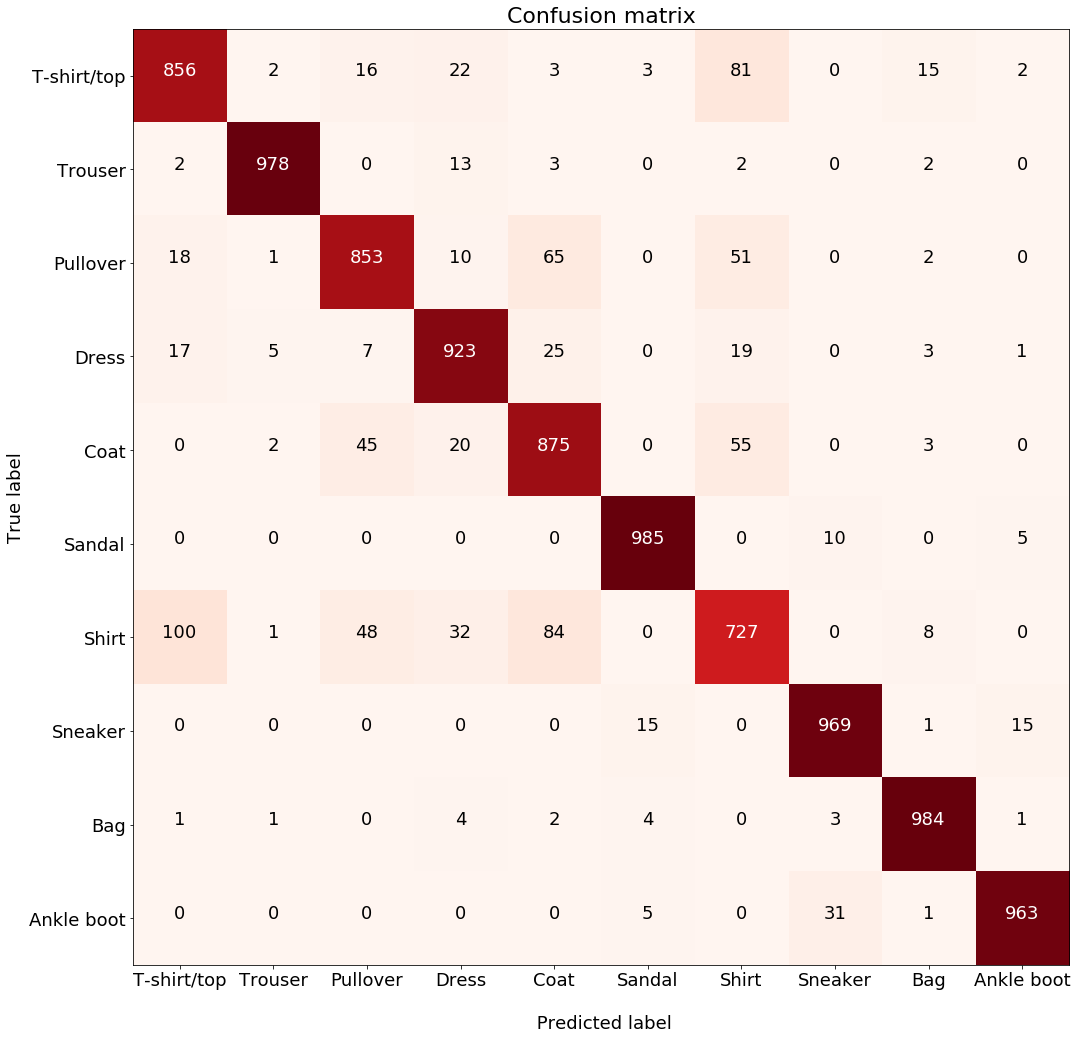

In [31]:
plot_confusion_matrix(cm, class_labels)

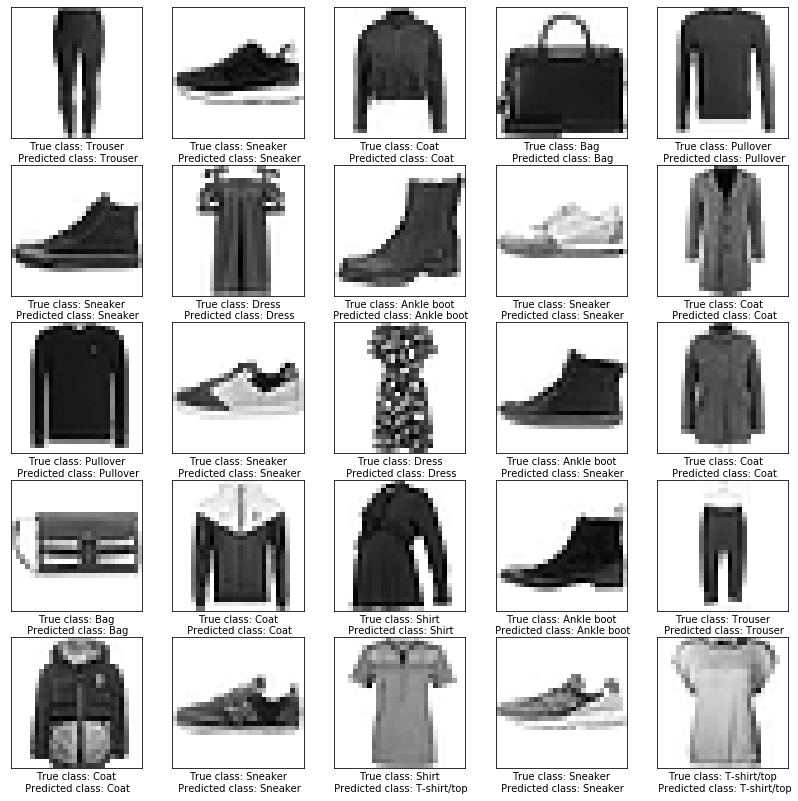

In [32]:
X_test_sq = np.squeeze(X_test, axis = 3)
plt.figure(figsize=(14,14))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    k = randrange(6000)
    plt.imshow(X_test_sq[k], cmap=plt.cm.binary)
    plt.xlabel('True class: ' + class_labels[y_test_class[k]] +
        '\n Predicted class: ' + class_labels[y_pred[k]])
plt.show()

### Conclusions

We see that our model has a bit of a trouble distinguishing among T-shirt/shirts/coat classes and sneaker/boot classes. It shows some overfit, but it still performs fine on a test set, its architecture is pretty simple and can be trained fairly quick. 